In [1]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [2]:
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Train Score: 23.29 RMSE
Test Score: 49.51 RMSE


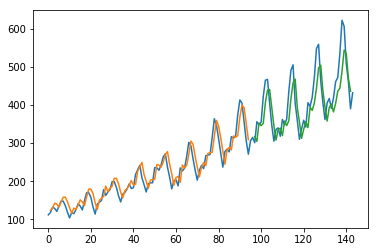

Train Score: 22.22 RMSE
Test Score: 49.07 RMSE


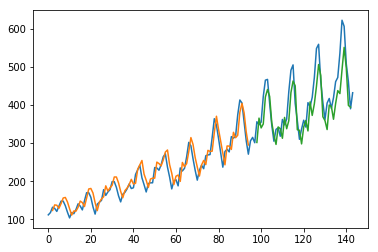

Train Score: 21.82 RMSE
Test Score: 48.56 RMSE


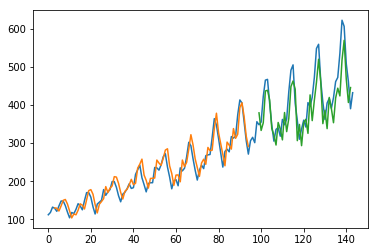

Train Score: 21.09 RMSE
Test Score: 71.12 RMSE


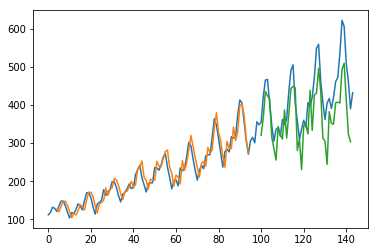

In [5]:
for look_back in range(1,5):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(40):
        model.fit(trainX, trainY, epochs=4, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()
#     model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()